In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from natsort import natsorted

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Time points

In [4]:
#####Change to class?

#artifacts
firstArtBegin = 0.081 
firstArtEnd = 0.0845 #generally 0.0845
secArtBegin = 0.131
secArtEnd = 0.134

#time points of traces for analysis
endCap = 0.02
firstStimBegin = 0.08
firstStimEnd = 0.125
secStimBegin = 0.136
secStimEnd = 0.175

#time points for finding NMDA decay time
endTauTrace = 0.58
beginTau = 0.115
endTau = 0.5

#for finding tau of capacitance traces
beginCapCurve = 0.00565
endCapCurve = 0.011
beginCapBaseline = 0.010
tauThreshold = 0.001

# Load experimental files and information

In [5]:
###Loop over all files in a folder to run automatically

#load excel file
waveInfo = pd.read_excel('2016.10.26_Cell1.xlsx')
waveInfo.head()

,waveNum,waveName,stimInt,notes
0,1,w7,40.0,noBic
1,2,w8,40.0,noBic
2,3,w9,40.0,noBic
3,4,w10,40.0,noBic
4,5,w11,40.0,noBic


In [144]:
#cell information
date = '2016.10.26'
cellNum = 1
age = 15

#Load csv
igor = pd.read_csv('igorForPython.csv', index_col = 0)

def selectWaves(df):
    '''Takes the data frame of raw igor traces and: 
    1) indexes waves by wave names (info from excel file)
    2) removes traces with NaN values'''
    igorWaves = df.pivot(index='sec', columns='id', values='pA')
    waves = igorWaves.filter(waveInfo['waveName'])
    waves = waves.dropna(axis = 0)
    return waves

#Reformat and select waves in waveInfo
allWaves = selectWaves(igor)
allWaves.head()

id,w7,w8,w9,w10,w11,w12,w13,w14,w15,w16,...,w75,w76,w77,w78,w79,w80,w81,w82,w83,w84
sec,,,,,,,,,,,,,,,,,,,,,
0.00000,0.948830,-3.059967,1.289867,-1.231331,-0.434429,2.303024,1.274933,0.613708,0.796894,1.317093,...,4.723364,1.359512,-1.399342,1.061974,1.475237,2.330578,-3.692544,-1.730488,-1.836338,-1.835079
0.00002,0.323860,-3.059967,-0.897526,-0.606361,-1.684368,2.615509,0.024994,0.301224,2.671803,2.567032,...,4.098394,1.359512,-1.711826,2.624397,0.850267,2.018093,-3.067575,-0.793034,-2.461308,-1.522594
0.00004,0.323860,-2.434998,0.039928,-0.293877,-1.996853,1.053085,0.649963,-0.636230,2.359318,2.567032,...,3.785910,1.359512,-1.711826,2.624397,2.412691,2.018093,-3.692544,-2.355457,-1.836338,-1.522594
0.00006,0.948830,-2.747482,0.039928,0.956062,-0.746914,0.740601,0.962448,0.613708,1.421864,1.942062,...,4.098394,1.671997,-1.086857,1.999428,0.850267,2.330578,-3.692544,-1.730488,-2.773792,-2.772533
0.00008,-0.301109,-1.185059,-1.210011,0.643578,-1.684368,2.303024,-0.287491,-0.011261,1.421864,3.504486,...,3.785910,1.047028,-1.711826,2.624397,1.162752,2.330578,-1.505151,-0.480549,-2.461308,-2.147564


# Capacitance decay
Identify and remove waves where the capacitance decay time is above a particular threshold

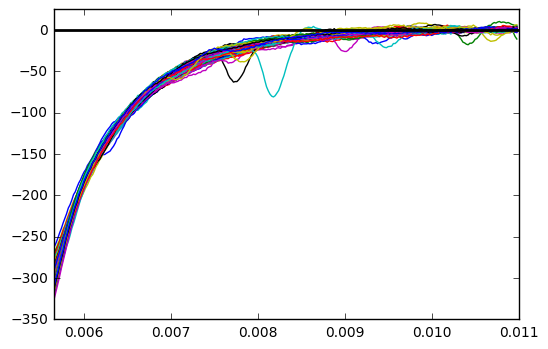

In [169]:
capCurve = allWaves[beginCapCurve:endCapCurve]

#normalize each cap trace to zero
normalizeCap = capCurve - np.mean(capCurve[beginCapBaseline:endCapCurve]) + 1.0e-10

x = normalizeCap
fig, ax = plt.subplots()
ax.plot(x)
ax.axhline(y=0, color='k', linewidth=2)
ax.axvline(x=0, color='k')
ax.axis([beginCapCurve, endCapCurve, -350, 25])
plt.show();


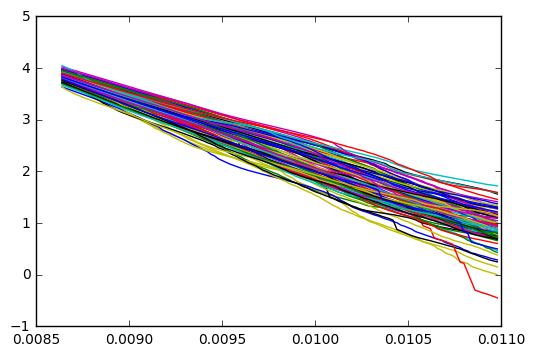

In [170]:
#Take log of amplitudes so can fit a linear model to cap traces
capLog = np.log(abs(normalizeCap))
smoothCurve = capLog.rolling(window = 150).mean()

plt.plot(smoothCurve)
plt.show();


In [171]:
#Fit a linear model
tracesForReg = smoothCurve.reset_index()
regModel = {}
for colname in tracesForReg.drop('sec', axis=1).columns:
    model = smf.ols(formula=colname+' ~ sec', data=tracesForReg)
    regModel[colname] = model.fit()

#Examine parameters of individual waves
#regModel['w7'].params

#Pull out coefficients of each trace
coefs = []
ids = []
for key in regModel:
    id = key
    ids.append(id)
    coef = regModel[key].params
    coefs.append(coef)

coefs = pd.DataFrame(coefs, index = natsorted(ids))
coefs.head()

#Calculate all capacitance taus (small tau = fast decay)
decayTimes = coefs.drop('Intercept', 1)
decayTimes = abs(1 / decayTimes)
decayTimes = decayTimes.rename(columns = {'sec':'capTau'})
decayTimes.head()


,Intercept,sec
w7,14.528275,-1213.540703
w8,13.745824,-1142.077453
w9,14.285390,-1178.544529
w10,15.564578,-1345.347451
w11,14.835317,-1275.753779


,capTau
w7,0.000824
w8,0.000876
w9,0.000849
w10,0.000743
w11,0.000784


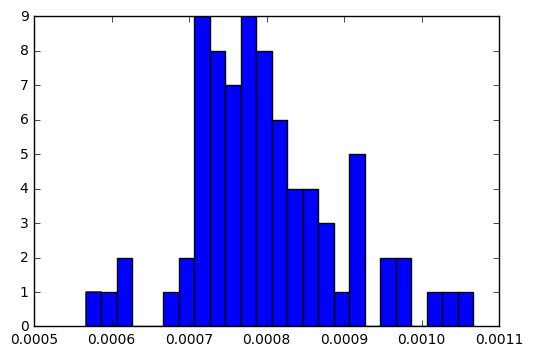

In [173]:
plt.hist(decayTimes['capTau'], bins = 25)
plt.show();


# What is the threshold for capacitance decay?
It is known that decreased capacitance implies increased resistance, which then decreases current flow. Therefore a slow capacitance decay time affects current responses of a neuron, decreasing current amplitudes at a fixed stimulation intensity compared to a faster decay time. The question is then, what is the threshold for capacitance decay times where the slow decay begins affecting the current amplitude?

In [215]:
#Plot cap decay times vs. amplitude vs. stimInt; what is the corr bw cap decay time and amplitude
#In other words how slow is too slow?
maxAmplitudes = pd.DataFrame(abs(allWaves.max()), columns = ['maximals'])
stimInt = waveInfo.drop(waveInfo.columns[[0, 3]], axis = 1)
stimInt = stimInt.set_index('waveName')
capVSmax = pd.concat([decayTimes, maxAmplitudes, stimInt], axis = 1)
capVSmax['logStimInt'] = capVSmax['stimInt'].apply(np.log)
capVSmax.head()

,capTau,maximals,stimInt,logStimInt
w7,0.000824,486.550110,40.0,3.688879
w8,0.000876,1786.540161,40.0,3.688879
w9,0.000849,572.511963,40.0,3.688879
w10,0.000743,1872.427246,40.0,3.688879
w11,0.000784,565.787903,40.0,3.688879


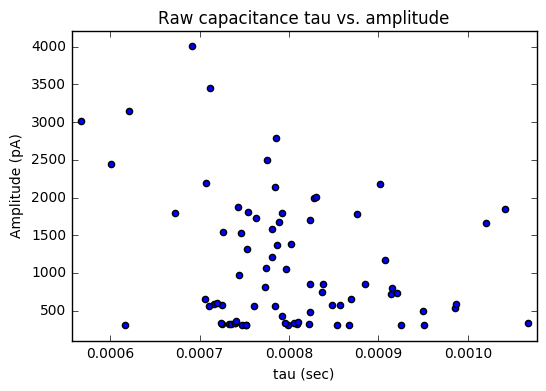

In [211]:
x_margins = 1.0e-5
y_margins = 200
plt.scatter(capVSmax['capTau'], capVSmax['maximals'])
plt.axis([capVSmax['capTau'].min() - x_margins, capVSmax['capTau'].max() + x_margins, 
          capVSmax['maximals'].min() - y_margins, capVSmax['maximals'].max() + y_margins])
plt.title('Raw capacitance tau vs. amplitude')
plt.xlabel('tau (sec)')
plt.ylabel('Amplitude (pA)')
plt.show();


In [ ]:
#normalize data points so that amplitude and tau are on same scale with mean zero and variance one
#color by logStimInt

# Removing unhealthy waves 

Unhealthy waves (or waves unsuitable for analysis) must be removed prior to calculations. For analysis AMPA and NMDA waves must be paired, i.e., an AMPA trace must have a matched NMDA trace and vice versa. 

Therefore, to remove unhealthy waves and their corresponding partners:
* Identify unhealthy waves by capacitance decay time, AMPA decay and leak currents
* Split waves into AMPA and NMDA waves
* Remove unhealthy waves by index in individual AMPA/NMDA dfs (indices are the same in the individual dfs)
* Create a list of ids of healthy cells and filter allWaves on list

In [133]:
#list below for test purposes only; should be identified automatically
unhealthy = [1,3,5,7]

def removeUnhealthy(df, unhealthyIndices):    
    '''Removes unsuitable/unhealthy traces by index'''
    AMPA = df[df.columns[::2]]
    NMDA = df[df.columns[1::2]]
    healthyA = AMPA.drop(AMPA.columns[unhealthyIndices], axis = 1)
    healthyN = NMDA.drop(NMDA.columns[unhealthyIndices], axis = 1)
    _ = list(zip(healthyA, healthyN))
    listHealthyWaves = [item for sublist in _ for item in sublist]
    healthyWaves = df.filter(listHealthyWaves)
    return healthyWaves

healthyWaves = removeUnhealthy(allWaves, unhealthy)
healthyWaves.head()

id,w7,w8,w11,w12,w15,w16,w19,w20,w23,w24,...,w75,w76,w77,w78,w79,w80,w81,w82,w83,w84
sec,,,,,,,,,,,,,,,,,,,,,
0.00000,0.948830,-3.059967,-0.434429,2.303024,0.796894,1.317093,-1.508808,-2.741348,1.437916,-16.500637,...,4.723364,1.359512,-1.399342,1.061974,1.475237,2.330578,-3.692544,-1.730488,-1.836338,-1.835079
0.00002,0.323860,-3.059967,-1.684368,2.615509,2.671803,2.567032,-1.508808,-3.991287,1.125431,-16.813122,...,4.098394,1.359512,-1.711826,2.624397,0.850267,2.018093,-3.067575,-0.793034,-2.461308,-1.522594
0.00004,0.323860,-2.434998,-1.996853,1.053085,2.359318,2.567032,-2.446262,-2.116379,0.500462,-14.938213,...,3.785910,1.359512,-1.711826,2.624397,2.412691,2.018093,-3.692544,-2.355457,-1.836338,-1.522594
0.00006,0.948830,-2.747482,-0.746914,0.740601,1.421864,1.942062,-2.446262,-3.366318,1.125431,-14.000759,...,4.098394,1.671997,-1.086857,1.999428,0.850267,2.330578,-3.692544,-1.730488,-2.773792,-2.772533
0.00008,-0.301109,-1.185059,-1.684368,2.303024,1.421864,3.504486,-3.383717,-3.678802,1.125431,-12.438335,...,3.785910,1.047028,-1.711826,2.624397,1.162752,2.330578,-1.505151,-0.480549,-2.461308,-2.147564


# Process waves
* Remove stimulus artifacts
* Normalize traces
* Split waves into sections for analysis